# CNN (Convolutional Neural Network)


1. Frederick Godiva (221401038)
2. Fico Yanton Jeremia Sibagariang (221401098)
3. Christian Nathaniel (221401136)


---


## Import Libraries


In [1]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Preprocessing Data


In [6]:
base_dir = './img'
categories = ['bakso', 'gado', 'gudeg', 'rendang', 'sate']

### Train Test Split


In [7]:
image_dir = './processed_images/'
train_dir = os.path.join(image_dir, 'train')
test_dir = os.path.join(image_dir, 'test')

In [8]:
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

In [9]:
for category in categories:
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=123)
    train_category_dir = os.path.join(train_dir, category)
    val_category_dir = os.path.join(test_dir, category)
    
    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_category_dir, image)
        shutil.copy(src, dst)
        
    for image in val_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(val_category_dir, image)
        shutil.copy(src, dst)

### Image Generator


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (80, 120),
    batch_size = 16,
    class_mode = 'categorical'
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (80, 120),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 5818 images belonging to 5 classes.
Found 1456 images belonging to 5 classes.


## Training Model


In [177]:
def build_model(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(80, 120, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [178]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=5,
    directory='tuner_directory',
    project_name='wiselens'
)

Reloading Tuner from tuner_directory\wiselens\tuner0.json


In [179]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [180]:
tuner.search(train_generator, epochs=100, verbose=1, validation_data=val_generator, callbacks=[early_stopping])

In [181]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [182]:
best_model = tuner.hypermodel.build(best_hps)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [183]:
history = best_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.3253 - loss: 1.4709 - val_accuracy: 0.4979 - val_loss: 1.1605
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.5134 - loss: 1.1357 - val_accuracy: 0.5762 - val_loss: 1.0972
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.5430 - loss: 1.1035 - val_accuracy: 0.5632 - val_loss: 1.1155
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.6109 - loss: 1.0052 - val_accuracy: 0.6380 - val_loss: 0.9465
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.6172 - loss: 0.9744 - val_accuracy: 0.5398 - val_loss: 1.2767
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.6344 - loss: 0.9346 - val_accuracy: 0.6126 - val_loss: 1.0711
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.6642 - loss: 0.8904 - val_accuracy: 0.5062 - val_loss: 1.2546
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.6744 - loss: 0.8709 - 

In [187]:
best_model.save("model-cnn.keras")

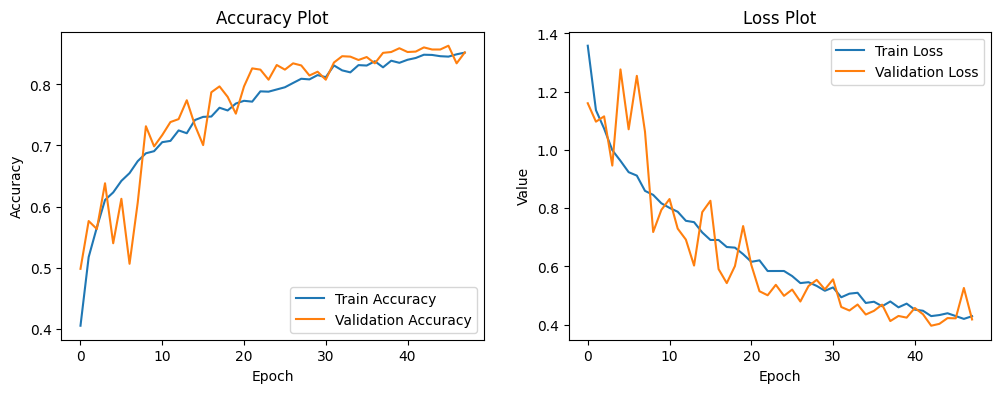

In [184]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

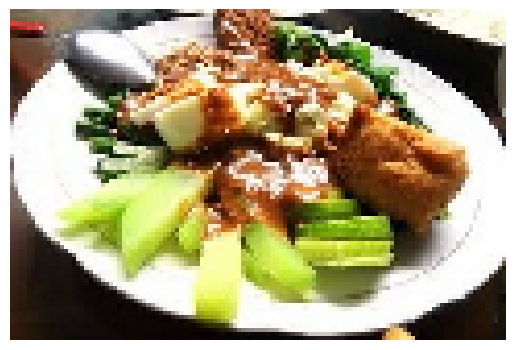

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediksi: gado


In [186]:
img_path = r"D:\\USU\\Semester 5\\Kecerdasan Buatan\\Final Project\\wiselens-model\\processed_images\\test\\gado\\gado gado-20014.jpg"
img = load_img(img_path, target_size=(80, 120))

plt.imshow(img)
plt.axis('off')
plt.show()

x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

classes = best_model.predict(x)
output = np.argmax(classes)

print(f"Prediksi: {categories[output]}")